# Analysis of the seasons 2015/16-2022/23 of the 2. Bundesliga

Since the preprocessing and the formatting of the data is done, let us start the analysis.

In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/Users/simonschulze/hs/data/train.csv')
test_df = pd.read_csv('/Users/simonschulze/hs/data/test.csv')

In [2]:
# specifying the desired features and targets

features = list(train_df.columns)
features.remove('result')

targets = ['result']

In [3]:
X_train, y_train = train_df[features].values, train_df[targets].values
X_test, y_test = test_df[features].values, test_df[targets].values

Now that the data was put into the right format and was standardized, we can start building models. Let us first use those that come from the scikit-learn package. The following models are going to be used:
- Decision Tree
- Support Vector Machine
- Light Gradient Boosting Machine (LGBM - from the lightgbm package)

Another model we are going to use is a neural network. It is going to be built with PyTorch:
- Neural Network

## Explanatory data analysis

Let us get a quick overview of how the matches ended during the specified seasons.

In [105]:
# training seasons

print(np.bincount(y_train.ravel().astype(int)))

[904 607 631]


In [106]:
# test season

print(np.bincount(y_test.ravel().astype(int)))

[142  73  91]


It is possible to see, that the classes are not perfectly balanced. However, synthesizing data to balance the classes is not going to be done, since the feature values would not be correct anymore. Furthermore, the classes are not too imbalanced, so that the models should be able to handle it.

## Model 1: Decision Tree

To start simple, let us first use a decision tree to predict the results of the games. One of the advantages of decision trees is that they are easy to interpret. Furthermore, they do not need standardized data. However, we will see if they are accurate enough to predict the results of the games, or not.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='gini', random_state=1)

In [31]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [32]:
y_pred = tree.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Test accuracy: 48.37%


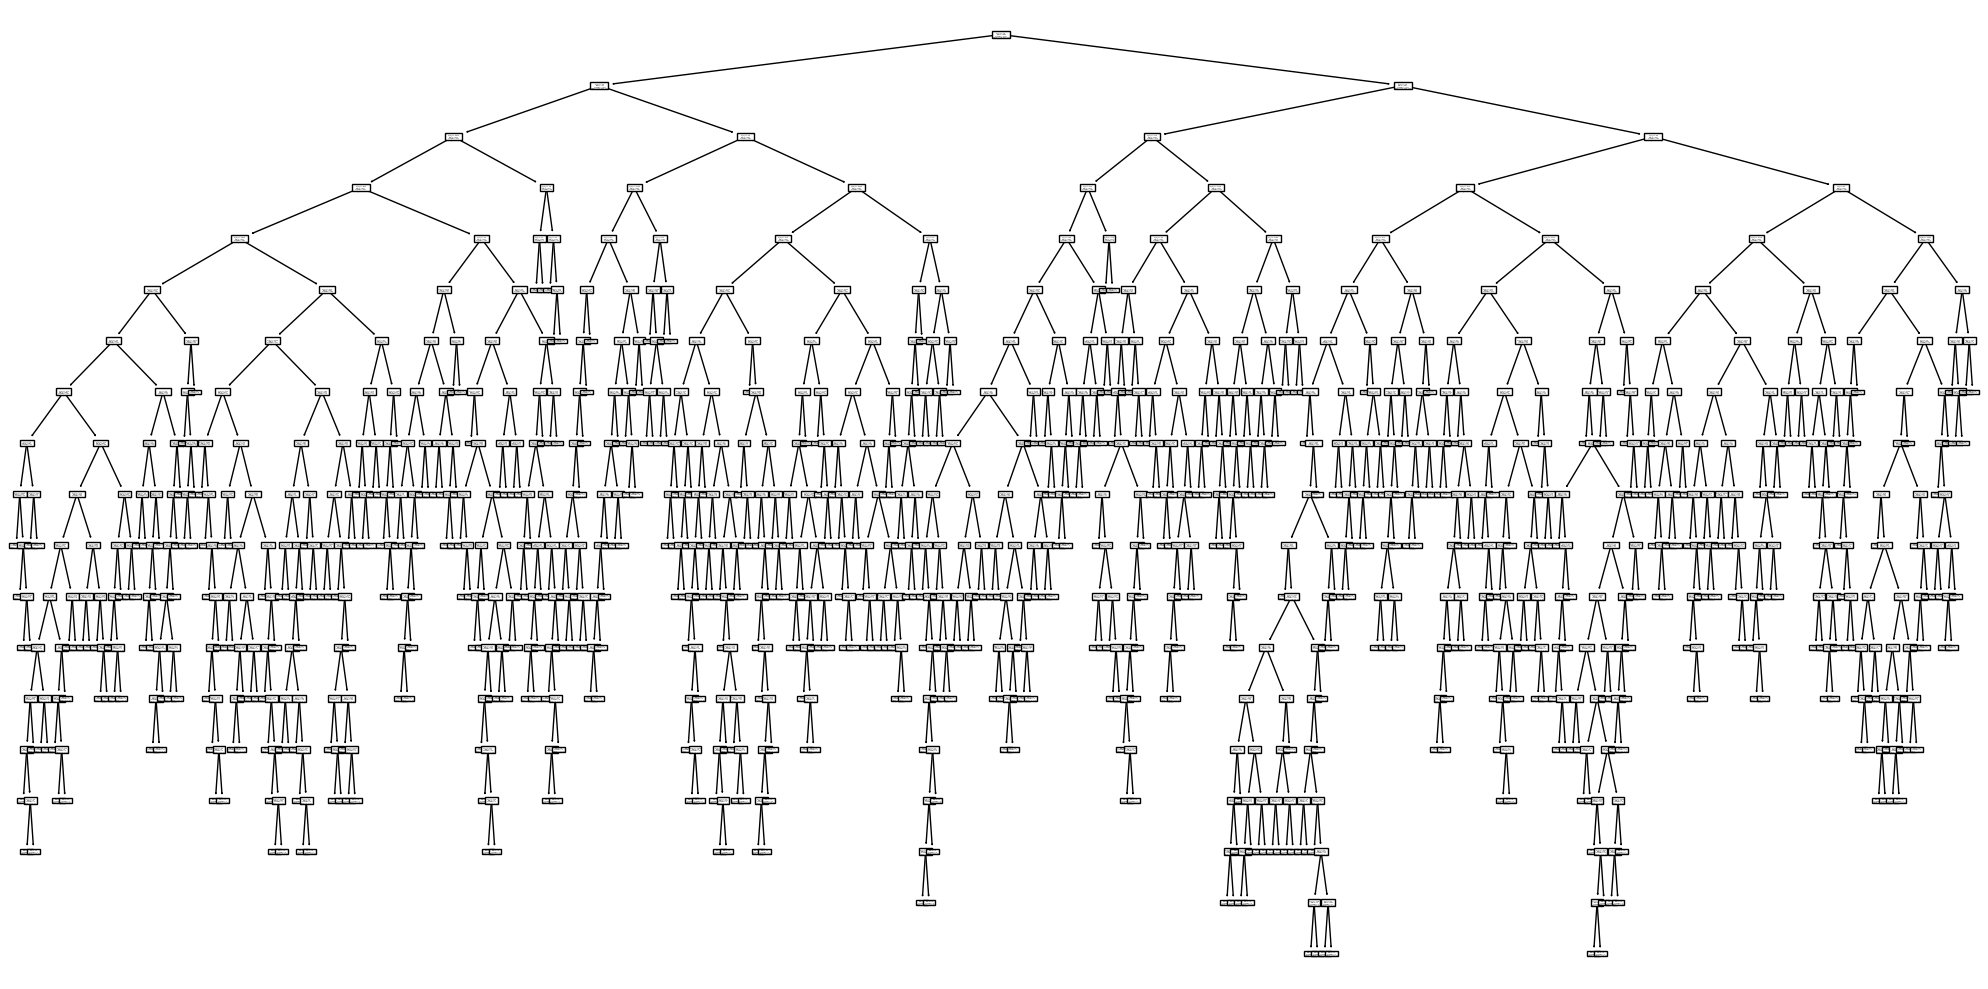

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 10))
plot_tree(tree)
plt.tight_layout()

This decision tree seems to be very complex and might be overfitting the data. Let us try to prune the tree to make it simpler.

Test accuracy: 51.63%


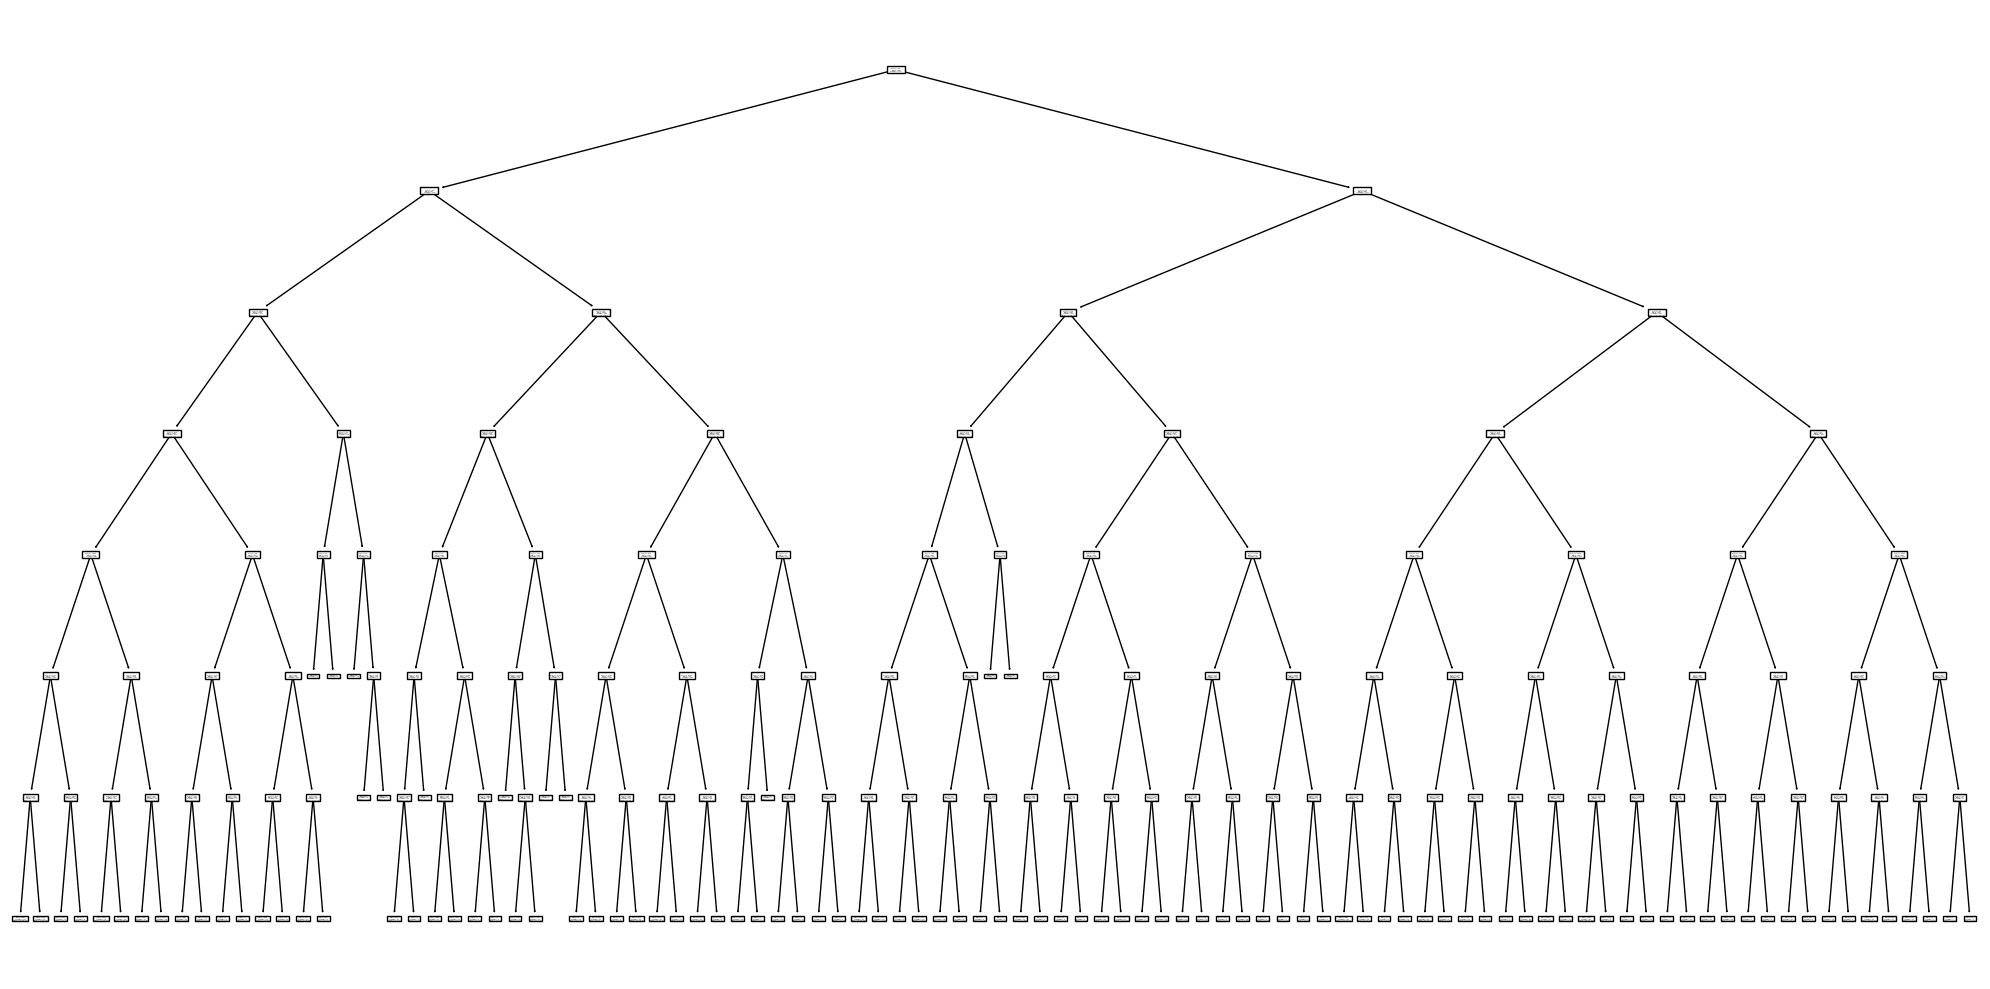

In [38]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=1)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

plt.figure(figsize=(20, 10))
plot_tree(tree)
plt.tight_layout()

In [47]:
# save the model

from joblib import dump

dump(tree, '/Users/simonschulze/hs/models/decision_tree.joblib')

['/Users/simonschulze/hs/models/decision_tree.joblib']

The accuracy improved slightly. Both trees are better than random guessing (33.33%), but they are not very accurate. Let us try to use a different model.

## Model 2: Support Vector Machine

Other machine learning models rather than the decision tree work best with standardized data in order to achieve better convergence and hopefully better accuracy. Let us try to use a support vector machine to predict the results of the games.

In [4]:
# standardizing the features to achieve better convergence

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Since we do not know the best parameters for the SVM, we will use a grid search. The following parameters will be used:
- C: regularization parameter
- kernel: kernel function

In [89]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm = SVC(probability=True, random_state=1)
gs = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [90]:
gs.fit(X_train, y_train.ravel())

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [91]:
# print the best parameters, the best score and get the best estimator

print(f"Best parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_*100:.2f}%")

svm = gs.best_estimator_

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best score: 55.52%


The best parameters are a linear kernel and a regularization parameter of 0.1. Let us see how accurate the model is by applying it on the test data.

In [92]:
y_pred = svm.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Test accuracy: 60.78%


The support vector machine achieved an accuracy of nearly 61%! This might not seem very much, compared with other machine learning tasks, but since football is a nearly unpredictable sport, this is a very good result. Furthermore, it competes with similar models that were trained on the english Premier League, which seems to be a more predictable league than the 2. Bundesliga.
But be careful: our model uses data that exists when the match is finished. Other models use data that is available before the match starts. This is a big difference, since the data that is available before the match starts is not as accurate as the data that is available after the match is finished. Therefore, the accuracy of our model is not directly comparable with those of other models.

In [53]:
# save the model

dump(svm, '/Users/simonschulze/hs/models/svm.joblib')

['/Users/simonschulze/hs/models/svm.joblib']

## Model 3: Light Gradient Boosting Machine

We have now trained a decision tree and a support vector machine. Let us try a different model, namely the Light Gradient Boosting Machine (LGBM). Other boosting models were used in comparable studies.

In [54]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=1)

We are going to use grid search again to find the best parameters for the LGBM. The following parameters will be used:
- n_estimators: number of boosting iterations
- learning_rate: learning rate
- reg_lambda: L2 regularization parameter

In [56]:
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'reg_lambda': [0.001, 0.01, 0.1, 1.0, 10.0]}

gs = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs.fit(X_train, y_train.ravel())

GridSearchCV(cv=10, estimator=LGBMClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 400,
                                          500],
                         'reg_lambda': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='accuracy')

In [57]:
# print the best parameters, the best score and get the best estimator

print(f"Best parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_*100:.2f}%")

lgbm = gs.best_estimator_

Best parameters: {'learning_rate': 0.01, 'n_estimators': 300, 'reg_lambda': 0.001}
Best score: 53.60%


The best parameters are 500 boosting iterations, a learning rate of 0.1 and a regularization parameter of 0.1. Let us see how accurate the model is by applying it on the test data.

In [58]:
y_pred = lgbm.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Test accuracy: 58.50%


The LGBM achieved an accuracy of nearly 59%. This is a good result, but not as good as the SVM.

In [59]:
# save the model

dump(lgbm, '/Users/simonschulze/hs/models/lgbm.joblib')

['/Users/simonschulze/hs/models/lgbm.joblib']

Now, we are finished with the scikit-learn models. The SVM achieved the best accuracy with nearly 61%. Let us now try to use a neural network to predict the results of the games.

## Model 4: Neural Network

Let us first set up torch-datasets and -dataloaders.

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# setting up torch-datasets and -dataloaders

train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.ravel()).long())
test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.ravel()).long())

batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Now it is time, to define a simple neural network with nn.Sequential.

In [7]:
# setting up the neural network

from collections import OrderedDict

model = nn.Sequential(OrderedDict({
    'fc1': nn.Linear(X_train.shape[1], 25),
    'relu1': nn.ReLU(),
    'fc2': nn.Linear(25, 16),
    'dropout': nn.Dropout(p=0.5), # to prevent overfitting
    'relu2': nn.ReLU(),
    'fc3': nn.Linear(16, 8),
    'relu3': nn.ReLU(),
    'fc4': nn.Linear(8, 3),
    'output': nn.Softmax(dim=1)
}))

In [8]:
model

Sequential(
  (fc1): Linear(in_features=20, out_features=25, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=25, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=8, out_features=3, bias=True)
  (output): Softmax(dim=1)
)

In [10]:
# number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1104


In [10]:
!pip install torchview

In [11]:
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')

model_graph = draw_graph(model, input_size=(1, 20), device='meta')
model_graph.visual_graph.render(filename='model_graph.png')

'model_graph.png.pdf'

In [63]:
# setting up the neural network

from collections import OrderedDict

model = nn.Sequential(OrderedDict({
    'fc1': nn.Linear(X_train.shape[1], 25),
    'relu1': nn.ReLU(),
    'fc2': nn.Linear(25, 16),
    'dropout': nn.Dropout(p=0.5), # to prevent overfitting
    'relu2': nn.ReLU(),
    'fc3': nn.Linear(16, 8),
    'relu3': nn.ReLU(),
    'fc4': nn.Linear(8, 3),
    'output': nn.Softmax(dim=1)
}))

In [63]:
# setting up the neural network

from collections import OrderedDict

model = nn.Sequential(OrderedDict({
    'fc1': nn.Linear(X_train.shape[1], 25),
    'relu1': nn.ReLU(),
    'fc2': nn.Linear(25, 16),
    'dropout': nn.Dropout(p=0.5), # to prevent overfitting
    'relu2': nn.ReLU(),
    'fc3': nn.Linear(16, 8),
    'relu3': nn.ReLU(),
    'fc4': nn.Linear(8, 3),
    'output': nn.Softmax(dim=1)
}))

Let us now define the training loop. We are going to use the Adam-optimizer from torch.optim and the CrossEntropyLoss-function from torch.nn.

In [64]:
num_epochs = 50

loss_hist = [0] * num_epochs
acc_hist = [0] * num_epochs

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

model.train()

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        acc_hist[epoch] += (torch.argmax(y_pred, dim=1) == y_batch.float()).float().sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    acc_hist[epoch] /= len(train_dl.dataset)
    
    print(f"""Epoch: {epoch+1}/{num_epochs},
        Training loss: {loss_hist[epoch]:.4f},
        Training accuracy: {acc_hist[epoch]*100:.2f}%""")

Epoch: 1/50,
        Training loss: 1.1034,
        Training accuracy: 30.44%
Epoch: 2/50,
        Training loss: 1.0876,
        Training accuracy: 40.99%
Epoch: 3/50,
        Training loss: 1.0597,
        Training accuracy: 45.75%
Epoch: 4/50,
        Training loss: 1.0279,
        Training accuracy: 50.37%
Epoch: 5/50,
        Training loss: 1.0099,
        Training accuracy: 51.96%
Epoch: 6/50,
        Training loss: 0.9900,
        Training accuracy: 54.30%
Epoch: 7/50,
        Training loss: 0.9881,
        Training accuracy: 53.97%
Epoch: 8/50,
        Training loss: 0.9780,
        Training accuracy: 55.00%
Epoch: 9/50,
        Training loss: 0.9759,
        Training accuracy: 55.18%
Epoch: 10/50,
        Training loss: 0.9717,
        Training accuracy: 55.74%
Epoch: 11/50,
        Training loss: 0.9663,
        Training accuracy: 56.63%
Epoch: 12/50,
        Training loss: 0.9707,
        Training accuracy: 56.63%
Epoch: 13/50,
        Training loss: 0.9622,
        Training

The results seem to be very good. Let us plot the training loss and the training accuracy.

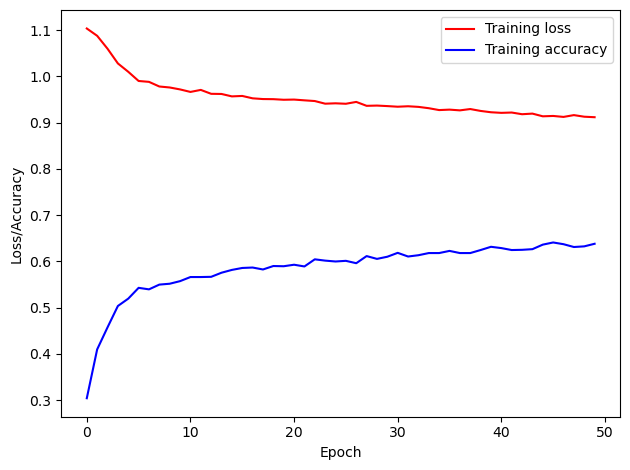

In [65]:
plt.plot(range(num_epochs), loss_hist, label='Training loss', color='red')
plt.plot(range(num_epochs), acc_hist, label='Training accuracy', color='blue')

plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

plt.legend(loc='best')
plt.tight_layout()

While the loss is decresing with every epoch, the accuracy is increasing. Let us now see how accurate the model is on the test data.

In [66]:
acc_test = 0

model.eval()

for x_batch, y_batch in test_dl:
    y_pred = model(x_batch)
    acc_test += (torch.argmax(y_pred, dim=1) == y_batch.float()).float().sum()
    
acc_test /= len(test_dl.dataset)

print(f"Test accuracy: {acc_test*100:.2f}%")

Test accuracy: 63.07%


The neural network achieves a test accuracy of approximately 63%. This is a good result, which is slightly better than the SVM. Let us now save the model.

In [67]:
# save the model

torch.save(model, "/Users/simonschulze/hs/models/neural_network.pt")

## Conclusion

We have now trained four different models to predict the results of the games in the 2. Bundesliga. The neural network achieved the best test accuracy with approximately 63%. This is a good result, which is slightly better than the SVM. However, the neural network is more complex than the SVM and therefore needs more time to train. The decision tree and the LGBM achieved accuracies of nearly 51% and 59%, respectively. These are good results, but not as good as the SVM and the neural network. However, the decision tree and the LGBM are easier to interpret than the SVM and the neural network.

# PDPs and Shapley Values

Let us now compute the Partial Dependence Plots and the Shapley Values for the SVM, LGBM and the neural network.

### Partial Dependence Plots

In [5]:
# load the models

import torch
import torch.nn as nn
from joblib import load
import matplotlib.pyplot as plt

lgbm = load('/Users/simonschulze/hs/models/lgbm.joblib')
neural_network = torch.load('/Users/simonschulze/hs/models/neural_network.pt')

In [6]:
from math import ceil

def partial_dependence_plot(model, X, feature_names: list, num_classes) -> None:
    
    """
    A function to create a simple partial dependence plot.
    :param model: The model for which the PDP should be plotted.
    :param X: The data on which the model should be applied. Passed either as a numpy.array (LGBM) or
            a torch.tensor (NN).
    :param feature_names: The names of the features.
    :return: Nothing. Plots the PDPs.
    """
    
    fig, ax = plt.subplots(4, ceil(len(feature_names) / 4), figsize=(25, 25))
    ax = ax.ravel()
    
    for index, feature_name in enumerate(feature_names):
        pdp = []
        for value in np.unique(X[:, index]):
            X_copy = X.copy()
            X_copy[:, index] = value
            if isinstance(model, nn.Sequential):
                pdp.append(model(torch.from_numpy(X_copy).float()).detach().numpy())
            else:
                pdp.append(model.predict_proba(X_copy))
        pdp = np.array(pdp)
        for i in range(num_classes):
            importance = np.std(pdp[:, :, i].mean(axis=1), ddof=1)
            ax[index].plot(np.unique(X[:, index]), pdp[:, :, i].mean(axis=1), label=f"Klasse {i}, {importance:.2f}")
        ax[index].set_xlabel(feature_name, fontsize=22)
        ax[index].set_ylabel("Wahrscheinlichkeit", fontsize=22)
        ax[index].legend(loc='best', prop={'size': 15})
        ax[index].scatter(np.unique(X[:, index]), [0] * len(np.unique(X[:, index])),
                          marker='|', s=10, color='black')
    plt.tight_layout()

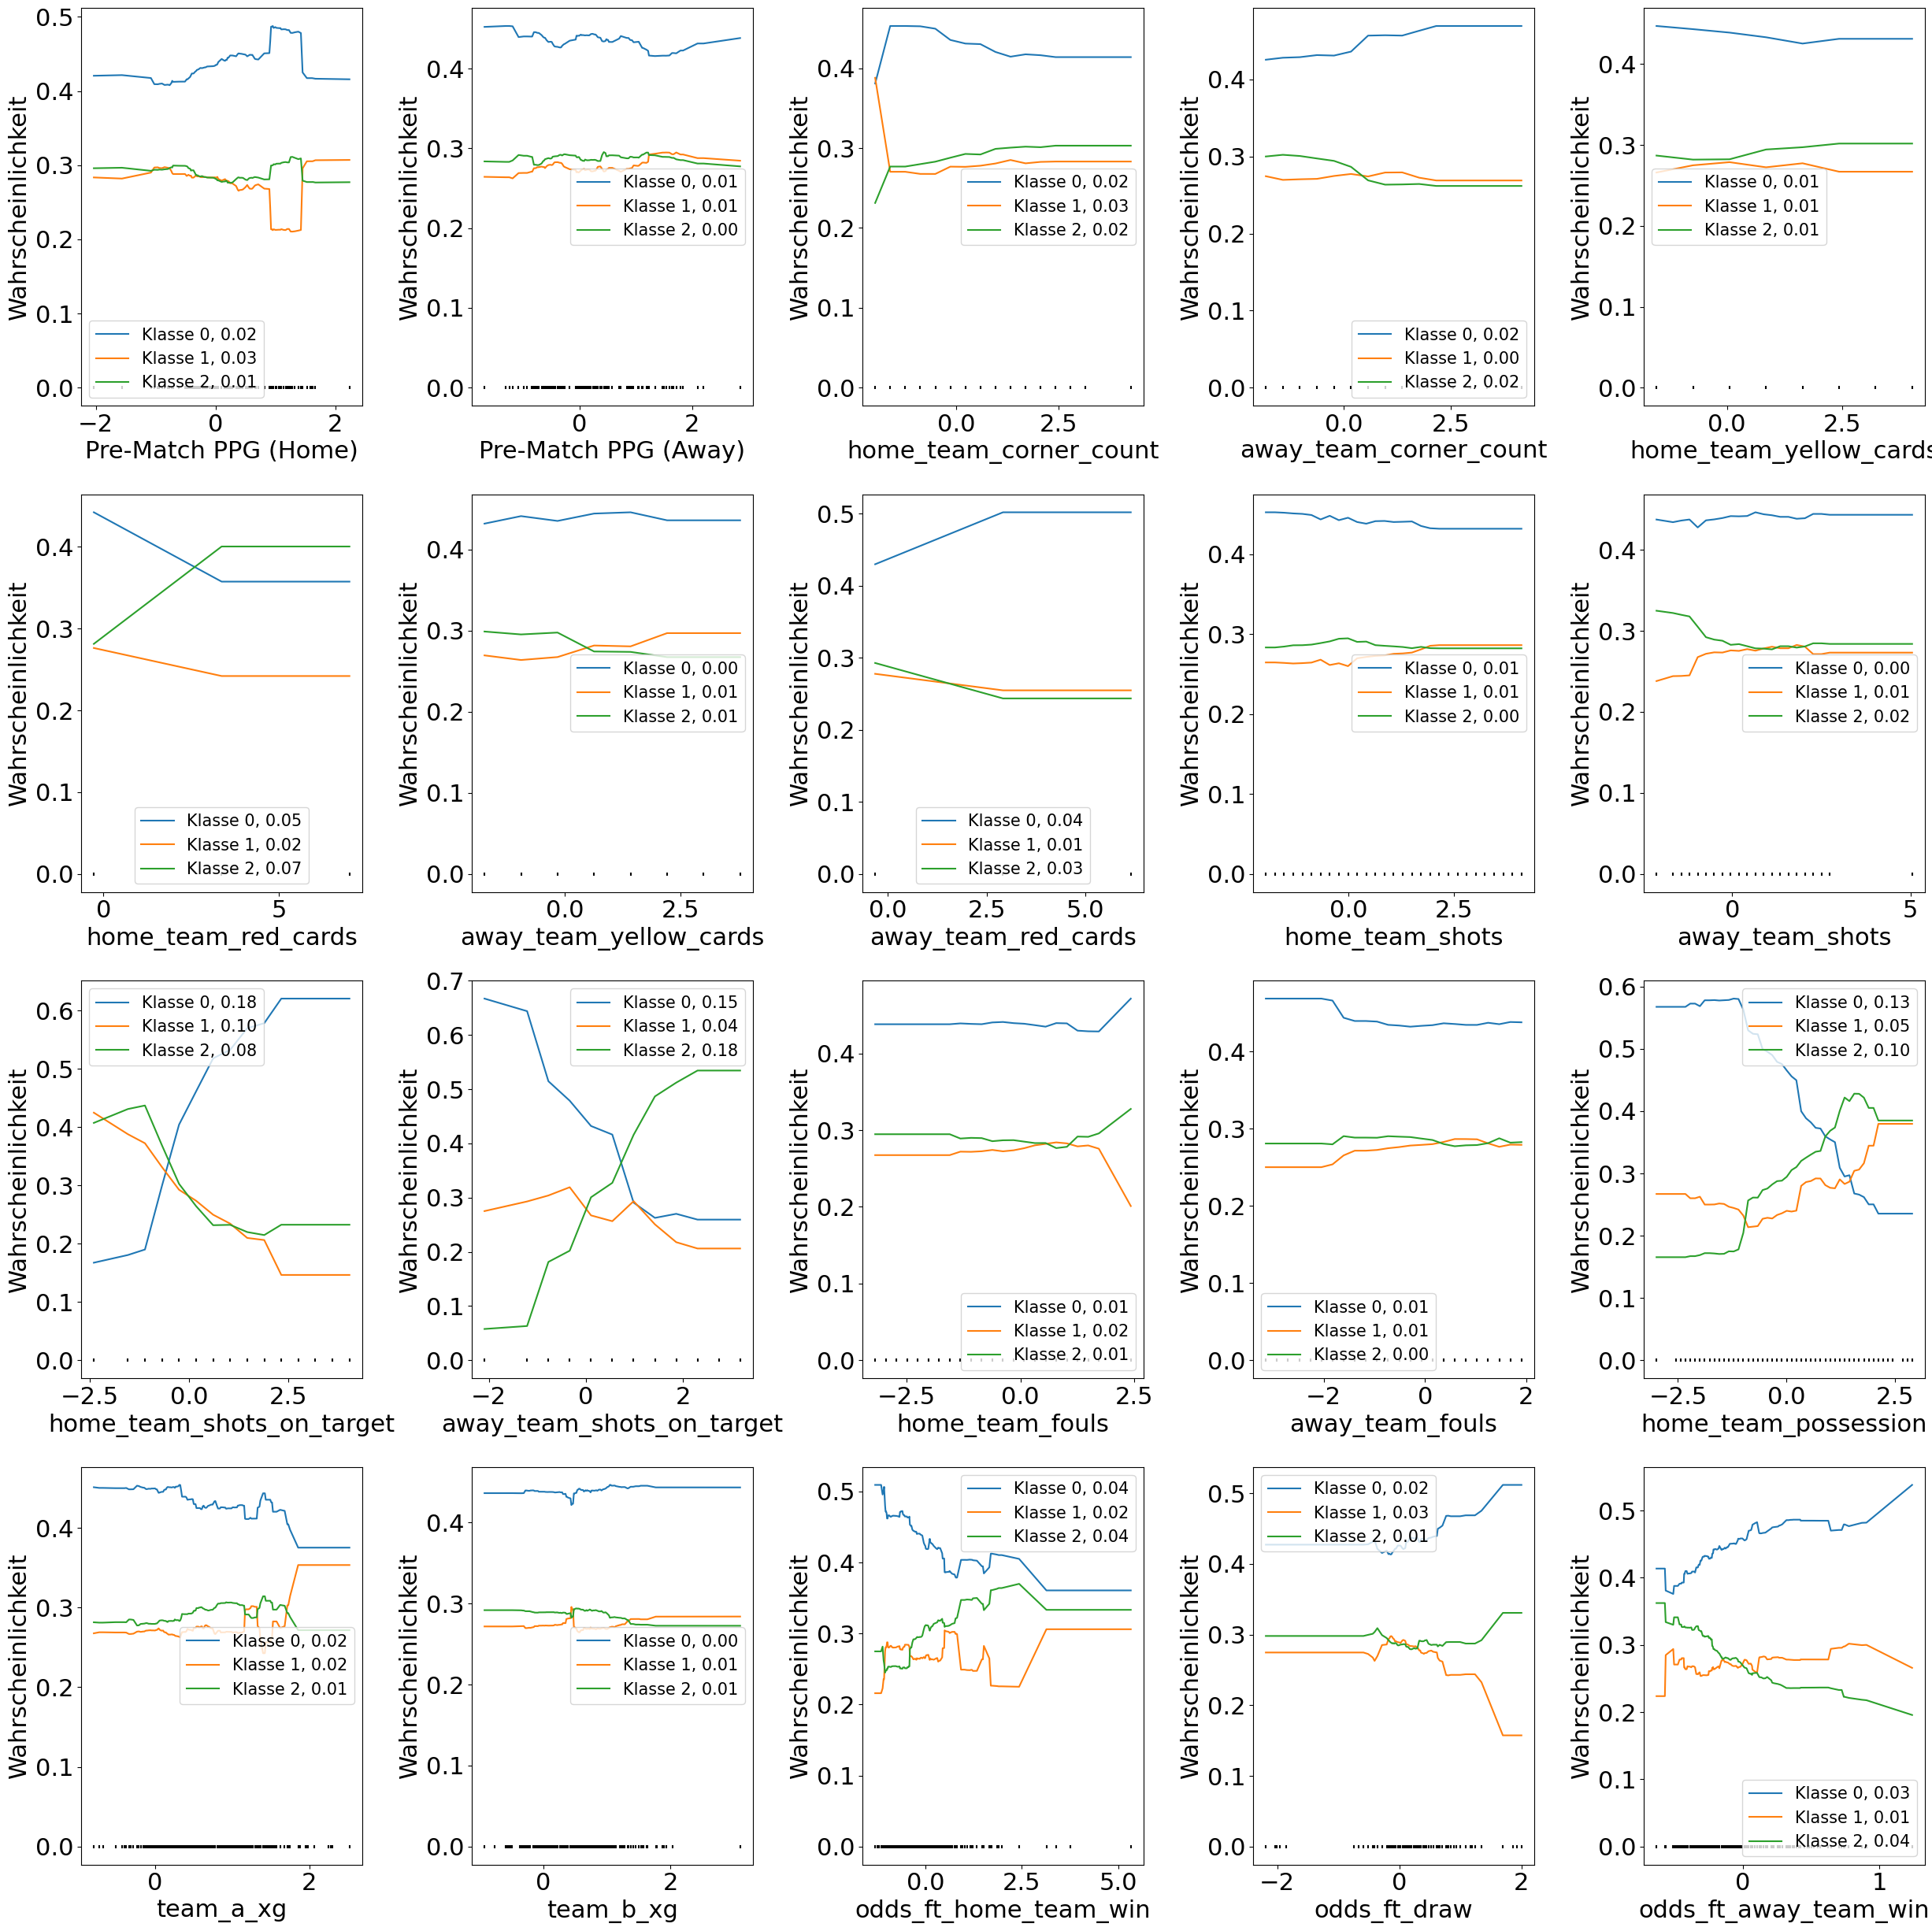

In [73]:
partial_dependence_plot(lgbm, X_test, features, 3)

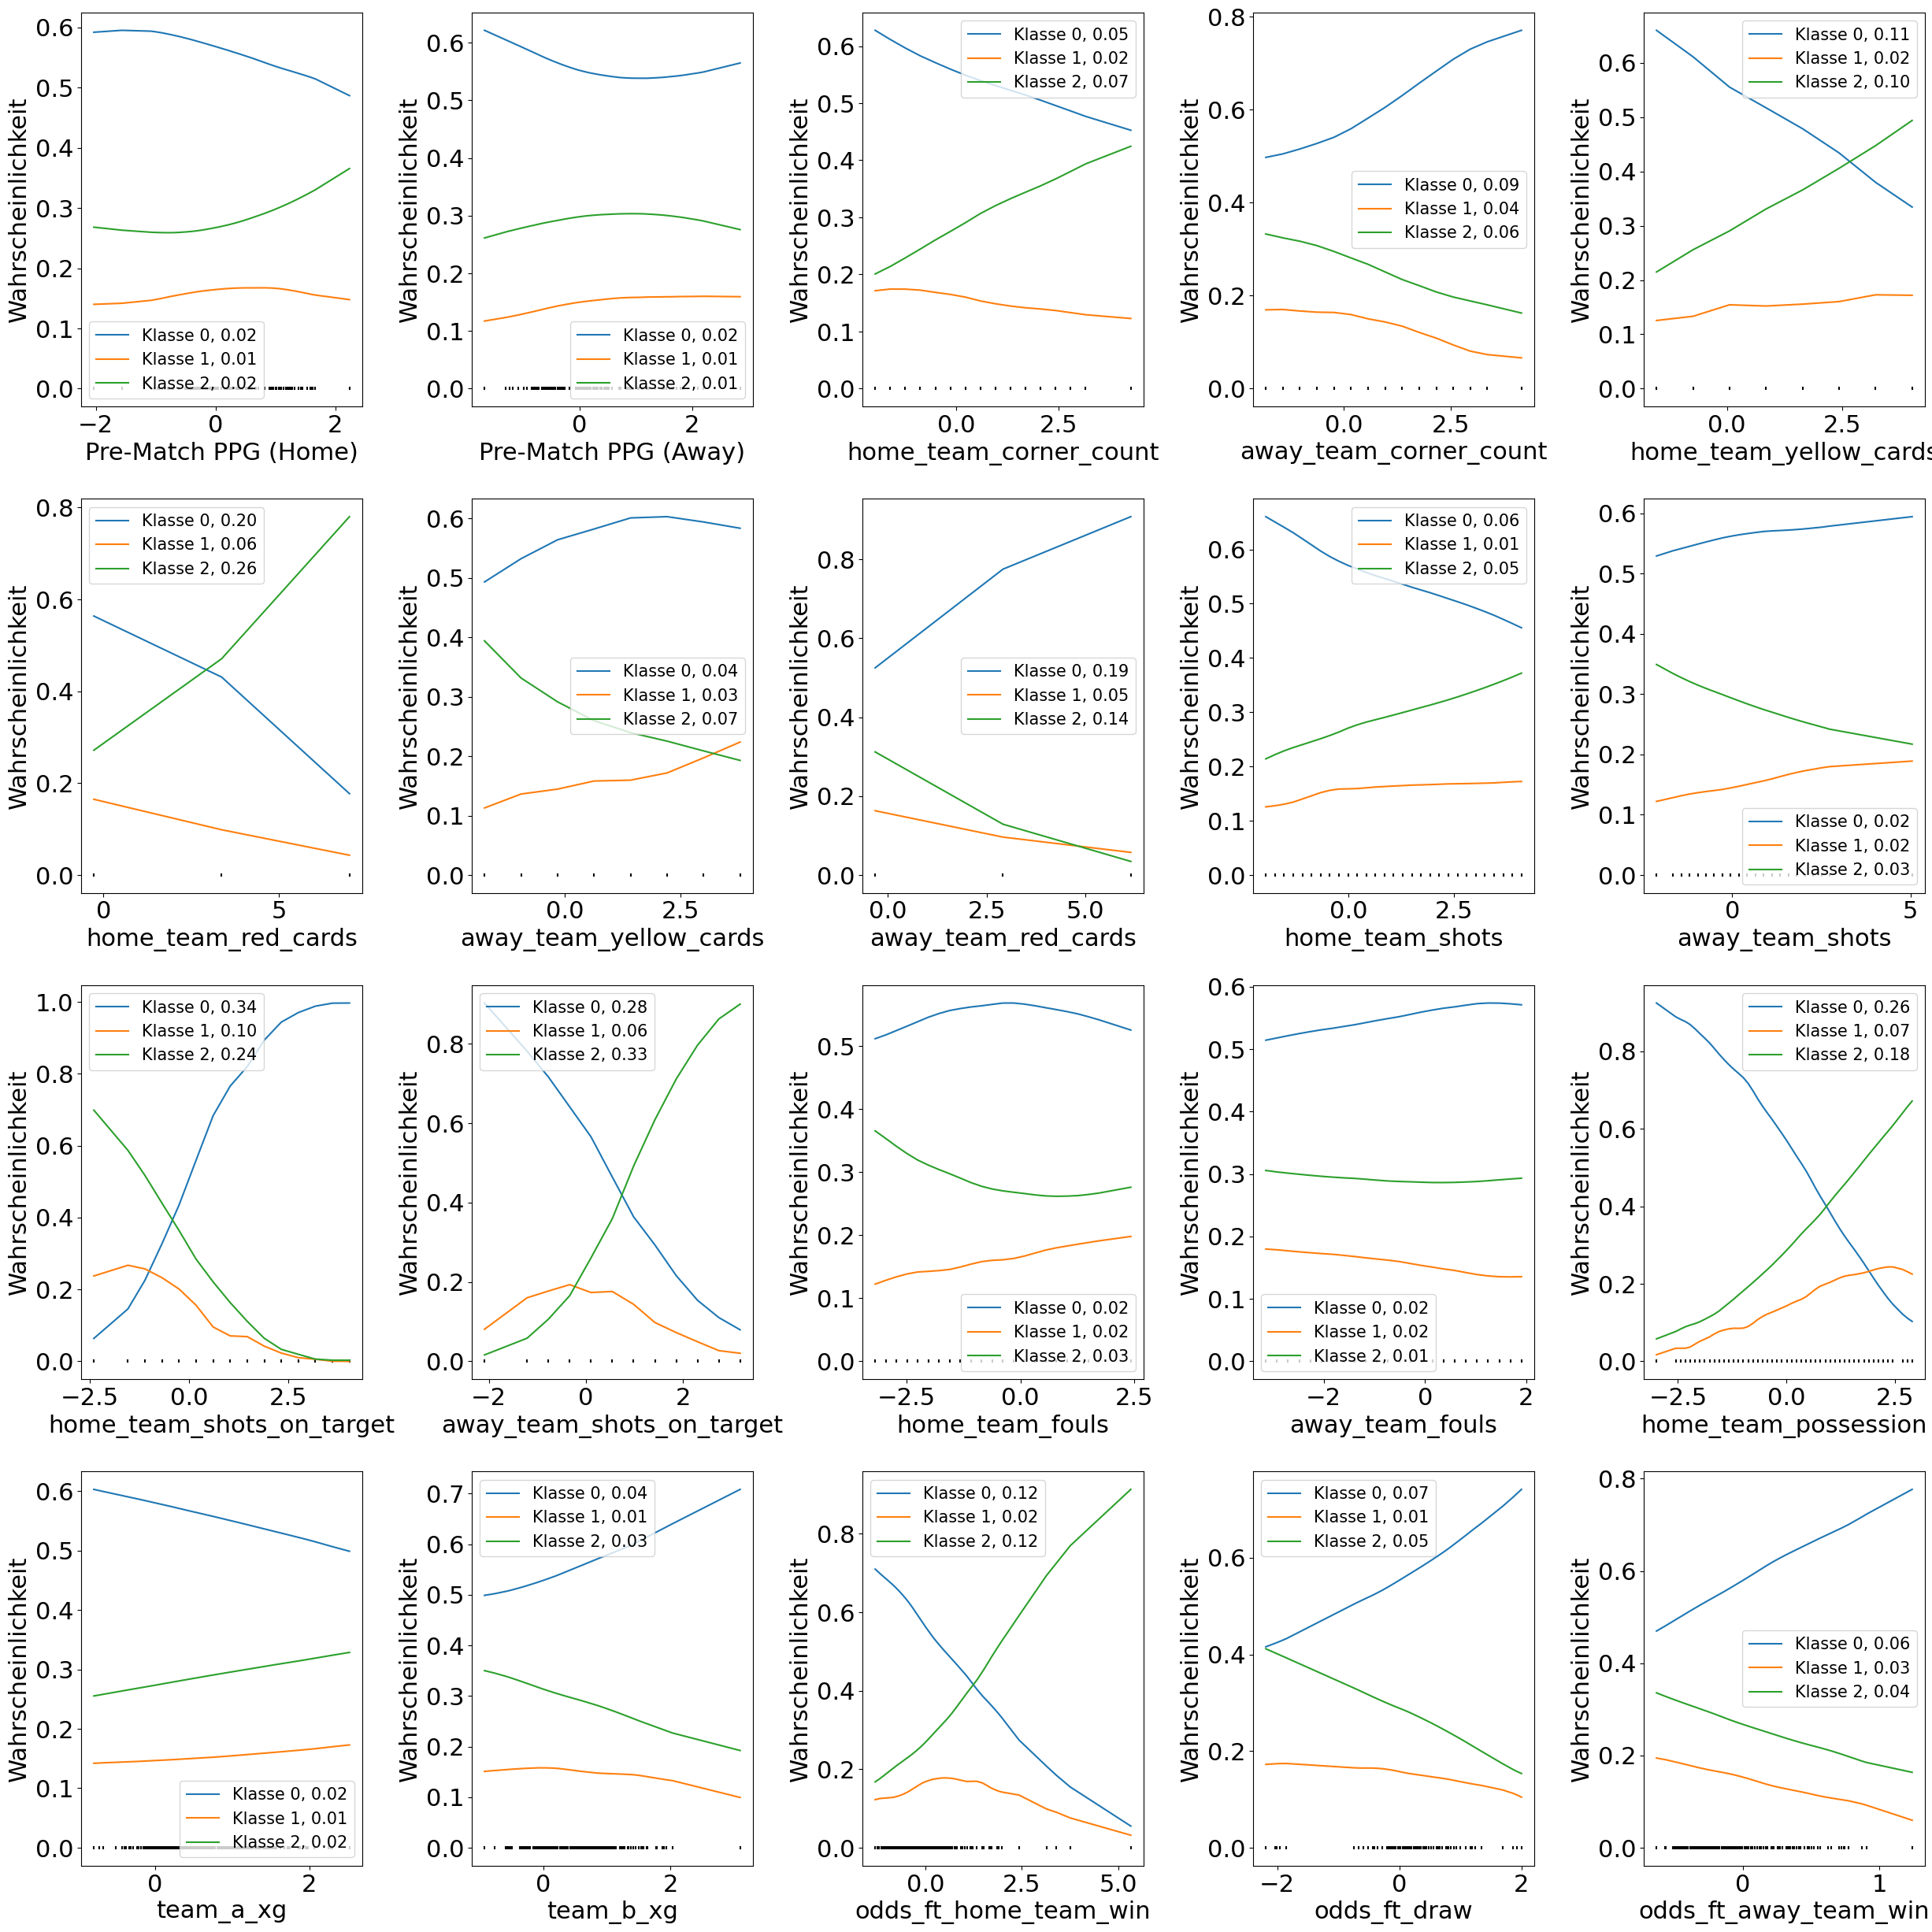

In [74]:
partial_dependence_plot(neural_network, X_test, features, 3)

### Shapley Values

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


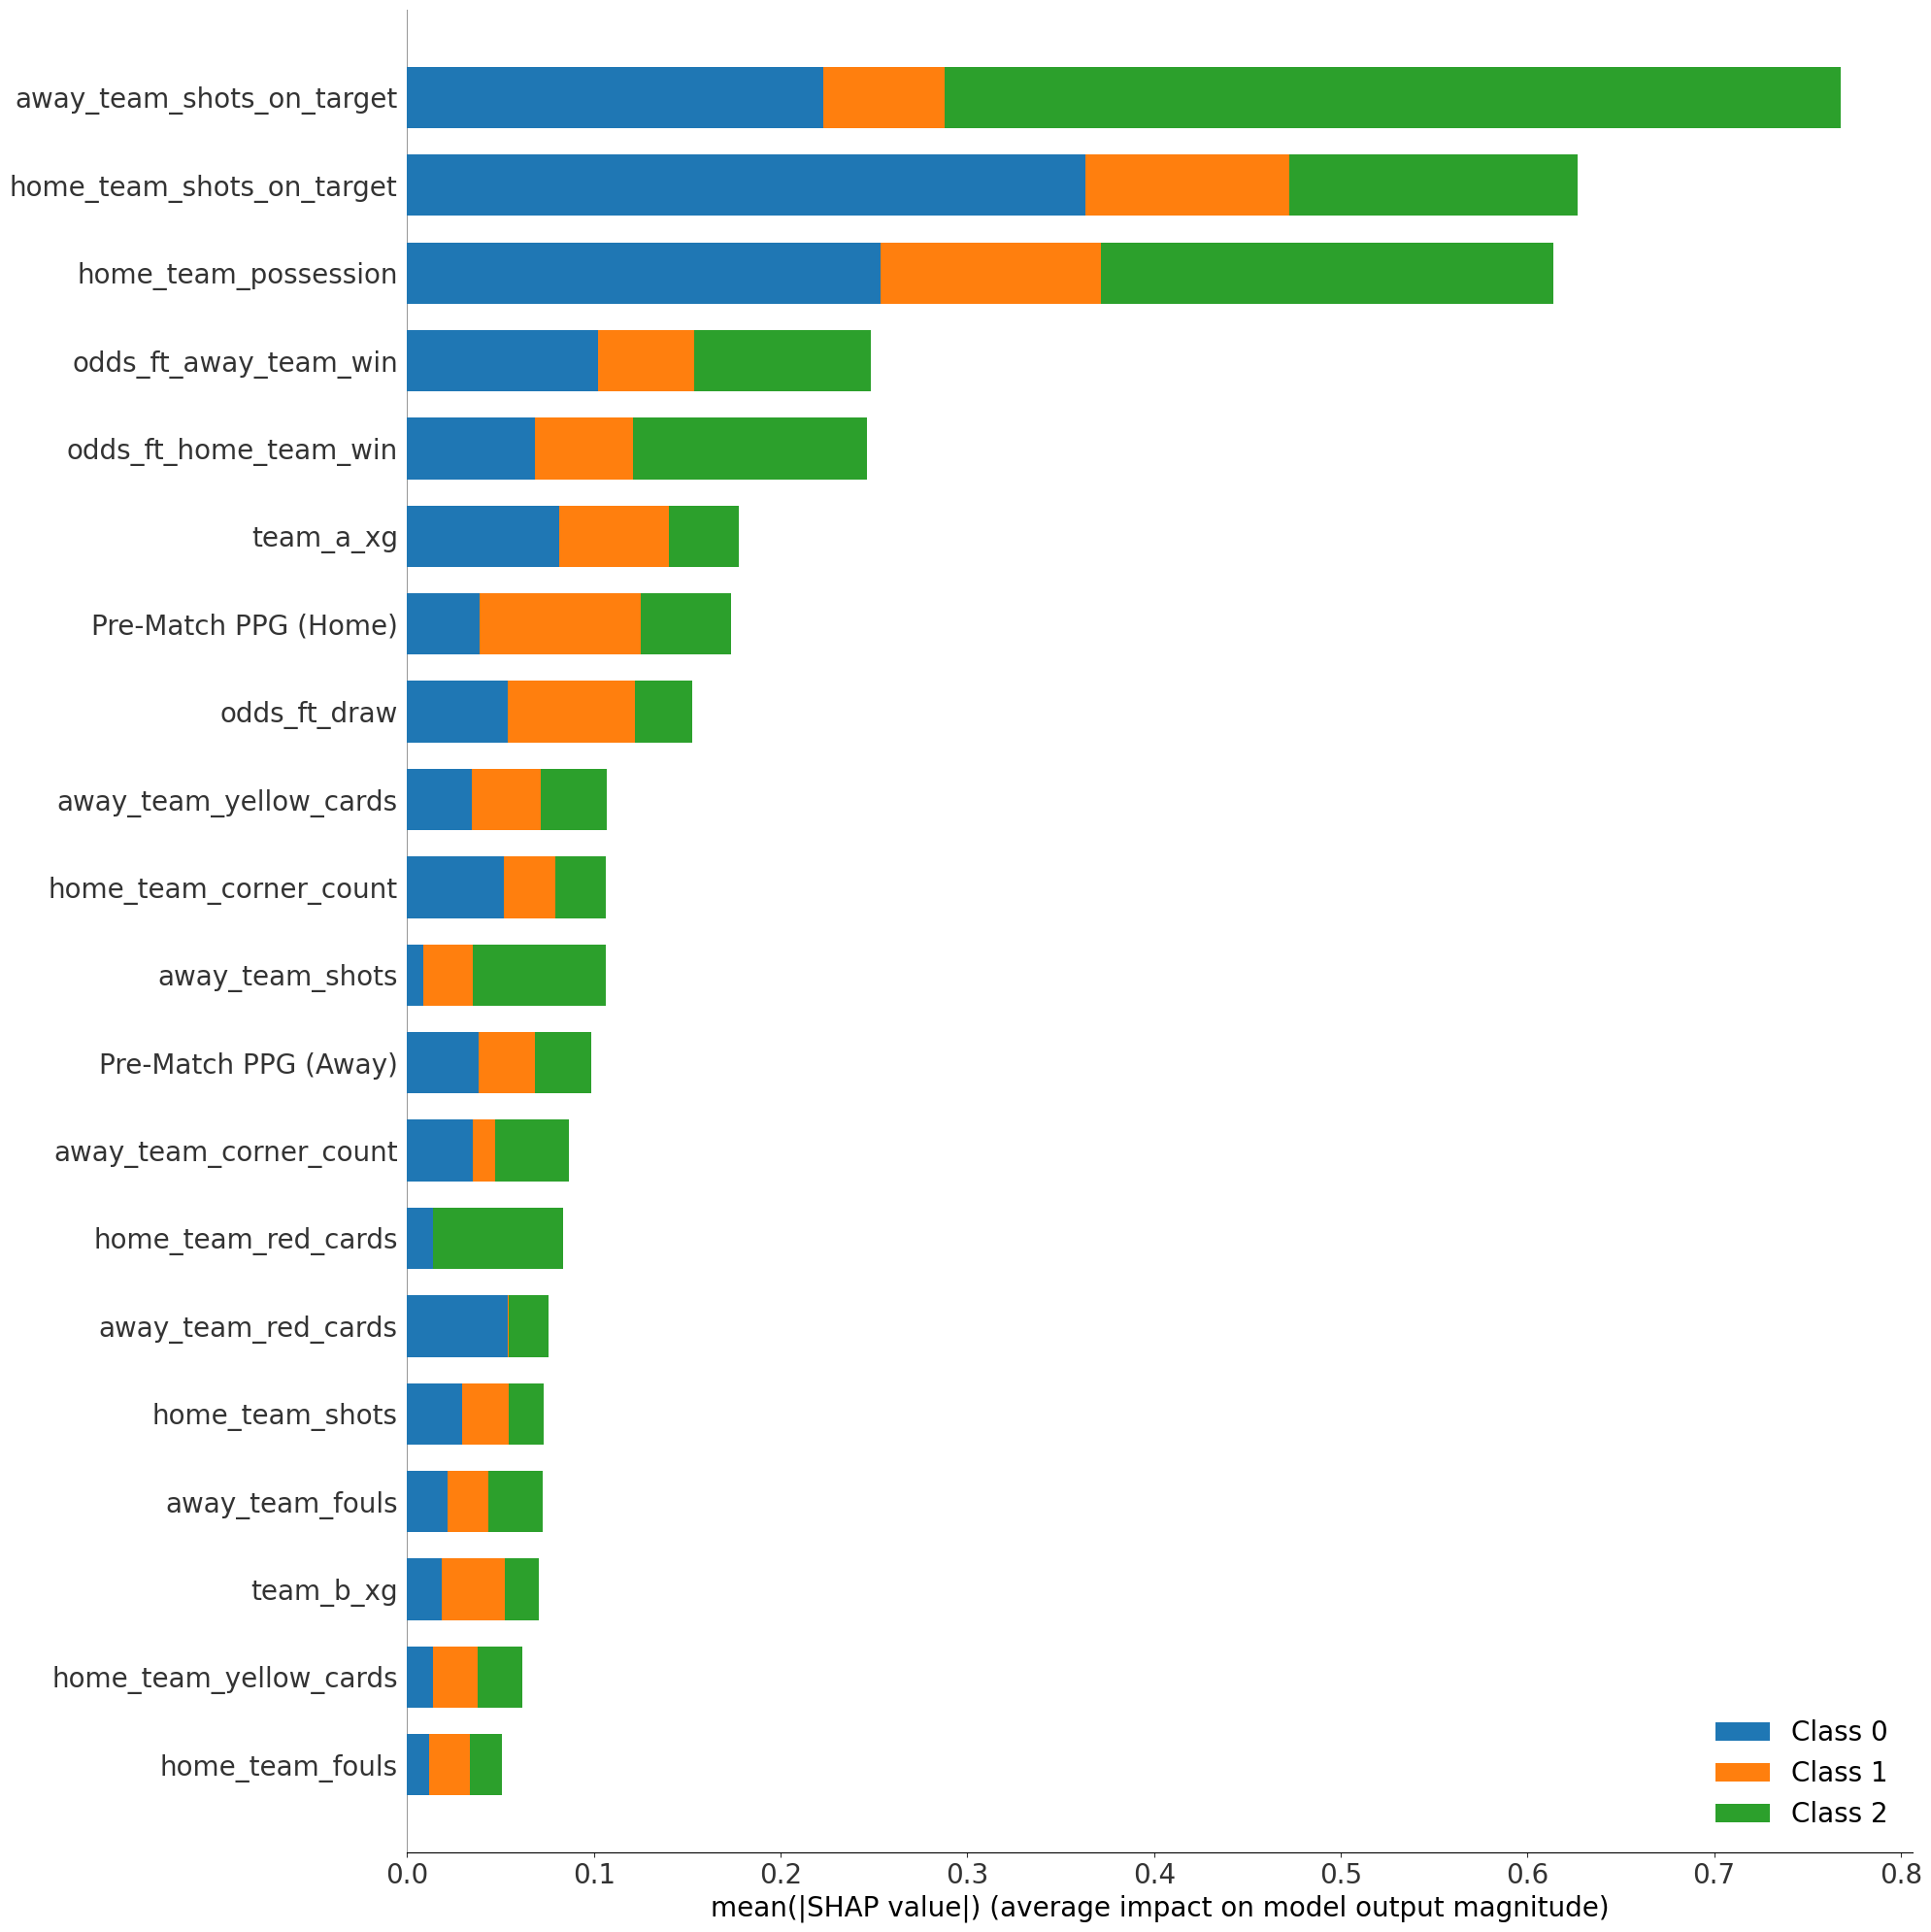

In [6]:
# load the module

import shap

shapley_values_lgbm = shap.TreeExplainer(lgbm).shap_values(X_test)
shap.summary_plot(shapley_values_lgbm, X_test, features, plot_type='bar', color=plt.get_cmap('tab10'), plot_size=(20, 20), class_inds=[0, 1, 2])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


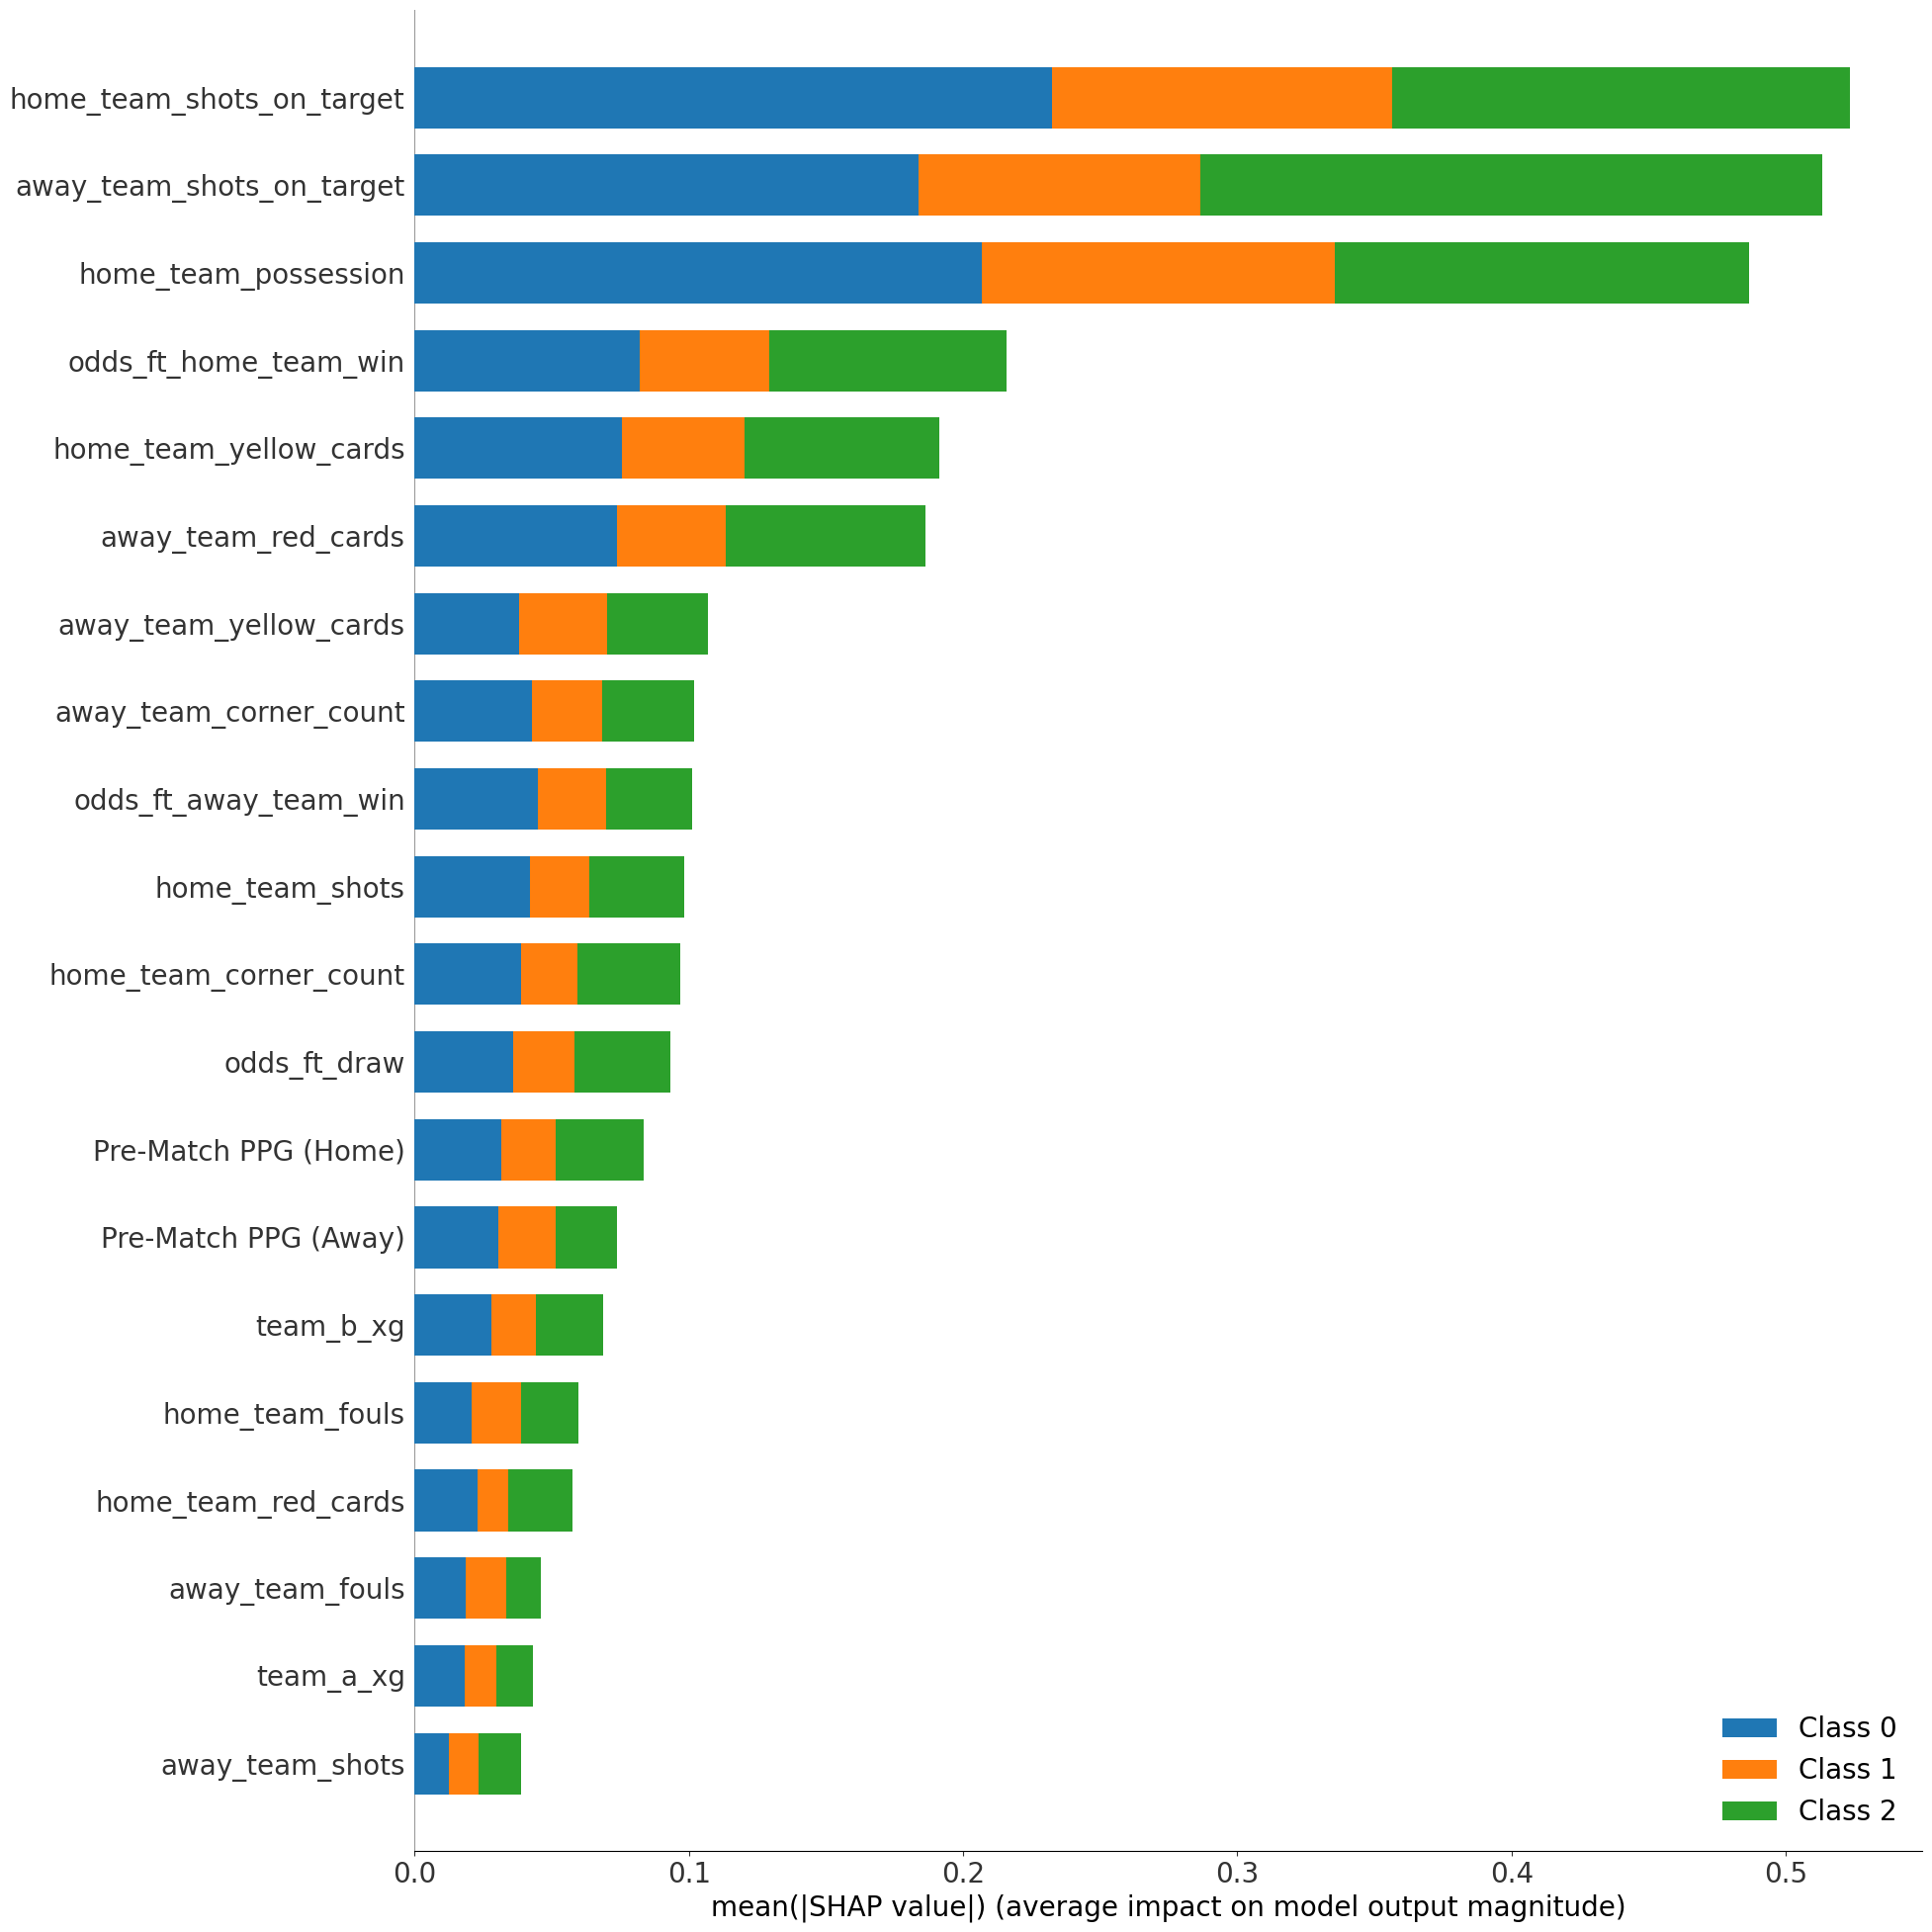

In [7]:

shapley_values_nn = shap.DeepExplainer(neural_network, torch.from_numpy(X_test).float()).shap_values(torch.from_numpy(X_test).float())
plt.rcParams.update({'font.size': 22})
shap.summary_plot(shapley_values_nn, X_test, features, plot_type='bar', color=plt.get_cmap('tab10'), plot_size=(20, 20), class_inds=[0, 1, 2])

Okay, now we know the most important features. Let us grab a sample and see how the model prediction changes, when we change the values of the most important features.

In [148]:
# get a sample

sample = test_df.loc[np.random.randint(0, len(test_df))]
f, t = np.array(sample[features].values).reshape(1, -1), sample[targets].values

In [149]:
# 0 - home wins, 1 - draw, 2 - away wins

print(t)

[0.]


In [143]:
# recall the features to correctly work with the indices

print(features)

['Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards', 'away_team_yellow_cards', 'away_team_red_cards', 'home_team_shots', 'away_team_shots', 'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 'team_a_xg', 'team_b_xg', 'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win']


In [144]:
f = sc.transform(f)

In [150]:
# modify a feature

f[0][14] = 3
print(lgbm.predict(f))

[2.]
